# Gaussian process

This notebook contains the simulations of Gaussian process with several different kernels. In the main text, we used rational quadratic kernel, but here we also show the results for several other types of kernels. We also report the results for other type of ``low-rank'' forecasting methods as discussed in Arun and Kung 1996.

In [1]:
import numpy as np
import sys
from pathlib import Path
# import random
# import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy.signal import savgol_filter
from tqdm import tqdm
import scipy as sp
sys.path.append("./utils")
import plots
# import pandas as pd
from numba import jit

from utils import analysis
from utils.forecast import PredictFuture

plt.style.use("./nature.mplstyle")

def standard_normalization(data):
    data = (data - np.mean(data)) / np.std(data)
    return data

In [2]:
def create_hankel_matrix(trajectory, memory, horizon):
    """
    Create Hankel matrix from a trajectory.
    """
    # z-score the trajecotry
    traj_z = standard_normalization(trajectory)
    hankel_mat = np.zeros((horizon, memory))
    for i in range(0, len(traj_z) - 2 * max(memory, horizon)):
        y_past = np.flip(traj_z[i : i + memory])
        y_future = traj_z[i + memory : i + (memory + horizon)]
        hankel_mat = hankel_mat + np.outer(np.squeeze(y_future), np.squeeze(y_past)) / (
            len(traj_z) - (memory + horizon)
        )

    return hankel_mat


def create_toeplitz_matrix(trajectory, memory, horizon):
    """
    Create Toeplitz matrix from a trajectory for past and future.
    """
    # z-score the trajecotry
    traj_z = standard_normalization(trajectory)
    toeplitz_past = np.zeros((memory, memory))
    toeplitz_future = np.zeros((horizon, horizon))

    for i in range(0, len(traj_z) - 2 * max(memory, horizon)):
        y_past = np.flip(traj_z[i : i + memory])
        y_future = traj_z[i + memory : i + (memory + horizon)]

        toeplitz_future = toeplitz_future + np.outer(
            np.squeeze(y_future), np.squeeze(y_future).transpose()
        ) / (len(traj_z) - 2 * H)

        toeplitz_past = toeplitz_past + np.outer(
            np.squeeze(y_past), np.squeeze(y_past).transpose()
        ) / (len(traj_z) - 2 * M)

    return (
        toeplitz_past,
        toeplitz_future,
    )

# Trajectory maker

def make_sin_traj(n_points, frequency, noise_level):
    t = np.arange(0, n_points)
    x = np.sin(t * 2 * np.pi * frequency) + np.random.normal(0, noise_level, n_points)
    return x

def make_tanh_trajectory(n_points, levels, noise_level):
    tanh_width = int(n_points / levels)
    for i in range(levels):
        t = np.arange(-int(tanh_width / 2), int(tanh_width / 2))
        x = np.tanh(t / 10) + 1 + i * 2 + np.random.normal(0, noise_level, len(t))
        if i == 0:
            data = x
        else:
            data = np.hstack((data, x))
    return data

In [3]:
def plot_prediction(
    trajectory, memory, horizon, prediction, title="", export_path=None, norm=True
):
    """Plot prediction versus ground truth."""
    trajectory_short = trajectory[: memory + horizon]
    if norm:
        prediction = normalize_pred(trajectory_short[memory:], prediction)

    fig, ax = plt.subplots(figsize=(2, 1))
    plt.plot(trajectory_short, label="ground truth", color="black")
    plt.plot(
        np.arange(memory, memory + horizon), prediction.flatten(), label="future pred.", ls=":"
    )
    # time point t mark
    plt.axvline(x=memory, color="grey", ls="-", alpha=0.5)
    plt.xlabel("Time (a.u.)")
    plt.ylabel("Value (a.u.)")
    plt.title(title)
    plt.legend()
    if export_path is not None:
        plt.savefig(export_path, dpi=300)
    plt.show()

    return prediction


def plot_filters(filters, title="", export_path=None):
    """Plots filters."""
    colors = plt.cm.coolwarm(np.linspace(0, 1, filters.shape[0]))

    fig, ax = plt.subplots(figsize=(2, 1))

    for x in range(filters.shape[0]):
        plt.plot(filters[x, :] / filters[x, :].max(), color=colors[x])

    plt.xlabel("Time (memory)")
    plt.ylabel("Value")
    plt.title(title)
    if export_path is not None:
        plt.savefig(export_path, dpi=300)
    plt.show()

# Gaussian process

We consider the following kernels: 
* Exponential kernel 
* Exponential quadratic kernel 
* Rational quadratic kernel

In [4]:
def power(x, p):
    return x ** p
# Using np.vectorize()
vfunc = np.vectorize(power)


In [5]:
# Set random seed
np.random.seed(42)
# Create a gaussian process
@jit(nopython=True)
def exponential_quadratic(xa, xb):
    """Exponentiated quadratic"""
    sq_norm = np.sum((xa[:, np.newaxis] - xb[np.newaxis, :])**2, axis=2)
    return np.exp(-0.5  * sq_norm)

# O-U process
@jit(nopython=True)
def ou_process(xa, xb, l=1):
    """OU process"""
    sq_norm = np.sum((xa[:, np.newaxis] - xb[np.newaxis, :]), axis=2)
    return np.exp(-np.abs(sq_norm)/l)

# @jit(nopython=True)
def rational_quadratic(xa, xb, l = 1, alpha = 1):
    """RQ process"""
    sq_norm = np.sum((xa[:, np.newaxis] - xb[np.newaxis, :])**2, axis=2)
    C = 1 + sq_norm / (2 * alpha * l ** 2)
    result = vfunc(C, -alpha)
    return result

# Sample from the Gaussian process distribution
nb_of_samples = 1_000  # Number of points in each function
number_of_functions = 200  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-10, 10, nb_of_samples), 1)
covariance_exp = exponential_quadratic(X, X)  # Kernel of data points
covariance_ou = ou_process(X, X, l = 3)  # Kernel of data points
covariance_ou_2 = ou_process(X, X,l=10)  # Kernel of data points
covariance_rq = rational_quadratic(X, X,l=1)  # Kernel of data points

# Draw samples from the prior at our data points.
gaussian_functions = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=covariance_exp, size=number_of_functions
)

ou_functions = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=covariance_ou, size=number_of_functions
)

# an extral ou process
ou_functions_2 = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=covariance_ou_2, size=number_of_functions
)

rq_functions = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=covariance_rq, size=number_of_functions
)



In [6]:
# store gaussian simulation for later use
if not Path("./results/").exists():
    Path("./results/").mkdir(parents=True, exist_ok=True)
root = './results/'
np.save( root + "gaussian_functions.npy", gaussian_functions)
np.save(root + "ou_functions.npy", ou_functions)
np.save(root + "ou_functions_2.npy", ou_functions)
np.save(root +"rq_functions.npy", rq_functions)

# Test the effect of noise level

In [7]:
# noise_levels = [0.001, 0.01, 0.1, 1.0]
noise_levels = [0.01, 0.1, 0.4]
memory = 75  # past 100 steps
horizon = 25  # predict 1 step ahead
store_filters_gaussian_noise = {method: {round(noise,3): [] for noise in noise_levels} for method in ["pca", "cca", "min_proj"]}
store_filters_ou_noise = {method: {round(noise,3): [] for noise in noise_levels} for method in ["pca", "cca", "min_proj"]}
store_filters_rq_noise = {method: {round(noise,3): [] for noise in noise_levels} for method in ["pca", "cca", "min_proj"]}
store_cca_rq_singular_values = {round(noise,3): [] for noise in noise_levels}
store_cca_ou_singular_values = {round(noise,3): [] for noise in noise_levels}
# store future filters
store_future_filters_rq_noise = {method: {round(noise,3): [] for noise in noise_levels} for method in ["pca", "cca", "min_proj"]}

for noise_level in tqdm(noise_levels):
    for gaussian_i in range(gaussian_functions.shape[0]):

        # GAUSSIAN
        predict_future_gauss = PredictFuture(
            gaussian_functions[gaussian_i,:] + np.random.normal(0, noise_level, nb_of_samples),
            memory,
            horizon,
            rank=None,
        )

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_gauss.predict_future(method="pca")
        )
        store_filters_gaussian_noise['pca'][round(noise_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_gauss.predict_future(method="cca")
        )
        store_filters_gaussian_noise['cca'][round(noise_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_gauss.predict_future(method="min_proj")
        )
        store_filters_gaussian_noise['min_proj'][round(noise_level,3)].append(past_filter)


        ### O-U Process
        predict_future_ou = PredictFuture(
            (ou_functions[gaussian_i,:] + ou_functions_2[gaussian_i,:])/2 + np.random.normal(0, noise_level, nb_of_samples),
            memory,
            horizon,
            rank=None,
        )
        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_ou.predict_future(method="pca")
        )
        store_filters_ou_noise['pca'][round(noise_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, singular_values = (
            predict_future_ou.predict_future(method="cca")
        )
        store_cca_ou_singular_values[round(noise_level,3)].append(singular_values)
        store_filters_ou_noise['cca'][round(noise_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_ou.predict_future(method="min_proj")
        )
        store_filters_ou_noise['min_proj'][round(noise_level,3)].append(past_filter)

        ### Rational Quadratic
        predict_future_rq = PredictFuture(
            rq_functions[gaussian_i,:] + np.random.normal(0, noise_level, nb_of_samples),
            memory,
            horizon,
            rank=None,
        )

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_rq.predict_future(method="pca")
        )
        store_filters_rq_noise['pca'][round(noise_level,3)].append(past_filter)
        store_future_filters_rq_noise['pca'][round(noise_level,3)].append(future_filter)

        future_prediction, x_partial, future_filter, past_filter,singular_values = (
            predict_future_rq.predict_future(method="cca")
        )
        store_filters_rq_noise['cca'][round(noise_level,3)].append(past_filter)
        store_cca_rq_singular_values[round(noise_level,3)].append(singular_values)
        store_future_filters_rq_noise['cca'][round(noise_level,3)].append(future_filter)

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_rq.predict_future(method="min_proj")
        )
        store_filters_rq_noise['min_proj'][round(noise_level,3)].append(past_filter)
        store_future_filters_rq_noise['min_proj'][round(noise_level,3)].append(future_filter)

100%|██████████| 3/3 [00:51<00:00, 17.19s/it]


In [8]:
def min_max_normalize(data):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data


def plot_filters_statistics(filters_dict, which_filter=0, title="", legend_title="", export_path=None):

    # colors coolwarm
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(filters_dict)))
    fig, ax = plt.subplots(figsize=(2.0, 1))
    # for each noise level, plot the mean and std of filters
    for k, noise_level in enumerate(filters_dict):
        filters_first = np.array(
            np.array(
                [
                    filters[which_filter, :] / np.max(abs(filters[which_filter, :]))*np.sign(filters[which_filter, 0])
                    for filters in filters_dict[noise_level]
                ]
            )
        )
        filters_mean = filters_first.mean(axis=0)
        filters_std = filters_first.std(axis=0)

        ax.plot(filters_mean, label=f"{noise_level}", color=colors[k])
        ax.fill_between(
            np.arange(len(filters_mean)),
            filters_mean - filters_std,
            filters_mean + filters_std,
            alpha=0.1,
            lw=0,
            color=colors[k],
        )

    # plt.yscale("symlog")
    plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title=legend_title)
    plt.xlabel("Time (memory)")
    plt.ylabel("Value")
    plt.title(title)
    plt.show()
    if export_path is not None:
        fig.savefig(export_path, dpi=300, bbox_inches="tight")


# Generate up-down stairs trajectory, with up 3 steps and down 3 steps
def test_traj_step(num_steps=4,transient_length=100,plot=False):
    num_steps = 4
    # transient_length = 100
    test_traj = []
    slope = 1
    # slopes = 2*np.random.rand(num_transients) + 0.5
    xs = np.linspace(-10,10, transient_length)

    for i in range(num_steps):
        transient = np.tanh(xs/slope)/2 + 1 + (i+1)
        test_traj.append(transient)
    for i in range(num_steps):
        transient = -np.tanh(xs/slope)/2 + 1 + (num_steps-i)
        test_traj.append(transient)
    test_traj = np.concatenate(test_traj)

    # add noise to the trajectory
    noise_std = 0.0
    test_traj += noise_std*np.random.randn(len(test_traj))
    # plot the trajectory
    if plot:
        fig, ax = plt.subplots(figsize=(3, 1))
        plt.plot(test_traj,linewidth=1.5, color='k')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        # remove tickets of the axis
        ax.set_xticks([])
        ax.set_yticks([])

        # remove the box and axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
    return test_traj

# define the action of filter to the test trajectory

def plot_filters_action(filters_dict,test_P, which_filter=0,title="", legend_title="", export_path=None,return_action=False):

    # colors coolwarm
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(filters_dict)))
    fig, ax = plt.subplots(figsize=(2.0, 1))
    all_actions = []
    # for each noise level, plot the mean and std of filters
    for k, noise_level in enumerate(filters_dict):
        filters_first = np.array(
            np.array(
                [
                    filters[which_filter, :] / np.max(abs(filters[which_filter, :]))*np.sign(filters[which_filter, 0])
                    for filters in filters_dict[noise_level]
                ]
            )
        )
        # action of the filter to the test trajectory
        filters_action = filters_first @ test_P
        all_actions.append(filters_action)
        # averaage action
        mean_action = filters_action.mean(axis=0)
        std_action = filters_action.std(axis=0)
        # all_actions.append(mean_action)

        ax.plot(mean_action, label=f"{noise_level}", color=colors[k])
        # ax.fill_between(
        #     np.arange(len(mean_action)),
        #     mean_action - std_action,
        #     mean_action + std_action,
        #     alpha=0.1,
        #     lw=0,
        #     color=colors[k],
        # )

    # plt.yscale("symlog")
    plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title=legend_title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.show()
    if export_path is not None:
        fig.savefig(export_path, dpi=300, bbox_inches="tight")
    if return_action:
        return all_actions


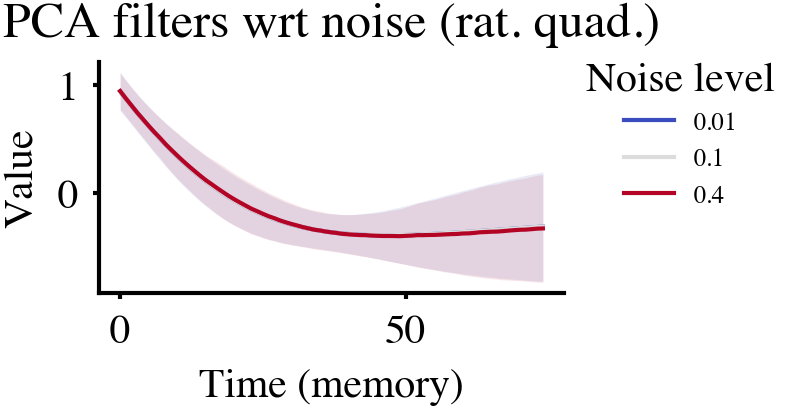

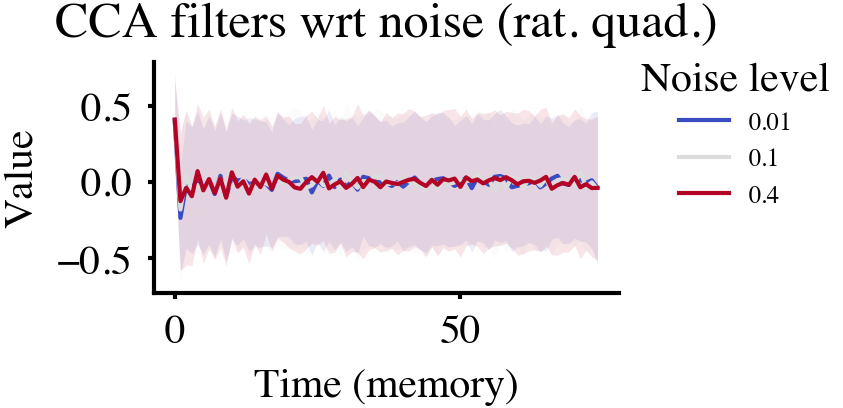

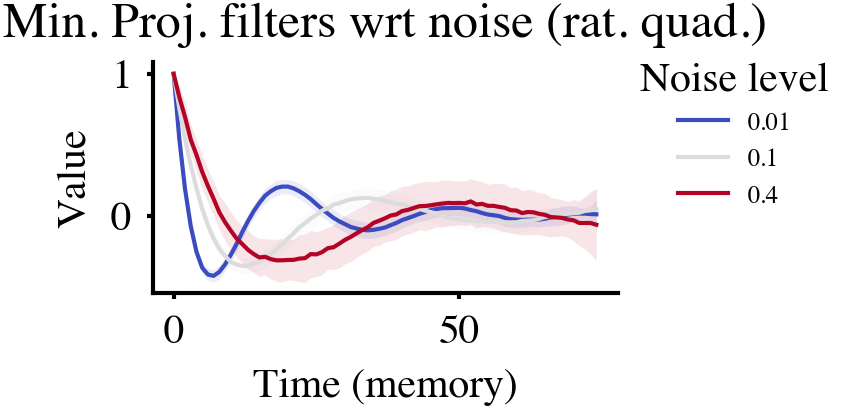

In [9]:
filter_select = 1
plot_filters_statistics(
    store_filters_rq_noise["pca"],
    which_filter=filter_select,
    title="PCA filters wrt noise (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/pca_filters_noise_level_rq.pdf",
)

plot_filters_statistics(
    store_filters_ou_noise["cca"],
    which_filter=filter_select,
    title="CCA filters wrt noise (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/cca_filters_noise_level_rq.pdf",
)

plot_filters_statistics(
    store_filters_rq_noise["min_proj"],
    which_filter=filter_select,
    title="Min. Proj. filters wrt noise (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/min_proj_filters_noise_level_rq.pdf",
)

In [10]:
# filter_list = store_filters_ou_noise['cca'][0.1]
# this part is for figure 1
noise_level = 0.1
ou_mean_filters = []
ou_mean_sv = []
for i in range(2):
    filter_array = np.array(
        [
        filters[i, :] / np.max(abs(filters[i, :]))*np.sign(filters[i, 0])
        for filters in store_filters_ou_noise['cca'][noise_level]
]
    )
    
    
    filters_mean = filter_array.mean(axis=0)
    ou_mean_filters.append(filters_mean)
sv_ou_arrary = np.vstack(store_cca_ou_singular_values[noise_level])
sv_ou_mean = sv_ou_arrary.mean(axis=0)

rq_mean_filters = []
for i in range(2):
    filter_array = np.array(
                np.array(
                    [
                        filters[i, :] / np.max(abs(filters[i, :]))*np.sign(filters[i, 0])
                        for filters in store_filters_rq_noise['cca'][noise_level]
                    ]
                )
            )
    filters_mean = filter_array.mean(axis=0)
    rq_mean_filters.append(filters_mean)
sv_rq_arrary = np.vstack(store_cca_rq_singular_values[noise_level])
sv_rq_mean = sv_rq_arrary.mean(axis=0)

# save the data
np.savez(root + "cca_rq_ou.npz", ou_mean_filters=ou_mean_filters, rq_mean_filters=rq_mean_filters, sv_ou_mean=sv_ou_mean, sv_rq_mean=sv_rq_mean)

Save cca filters for figure 2

In [11]:


# Save the data in a single .npz file to preserve the structure
np.savez(
    root + "fig2_cca_filter_sv.npz",
    filters=store_filters_rq_noise['cca'],
    sv=store_cca_rq_singular_values
)

## Test the whether the action of filter changes
Action of the filters, whether they change with the noise level or not.

In [12]:
def staircase_function(num_stairs, duration):
    """
    Generate a staircase function with num_stairs steps and a total duration of duration.
    """
    ampl_up = np.arange(num_stairs)
    # replicate each amplitude duration times
    # ampl_up = np.tile(ampl_up, int(duration/num_stairs))
    ampl_down = np.arange(num_stairs-1)[::-1]
    # concatenate the up and down amplitudes
    ampl = np.concatenate((ampl_up, ampl_down))
    temp = np.tile(ampl, (duration,1))
    return temp.T.flatten()
    

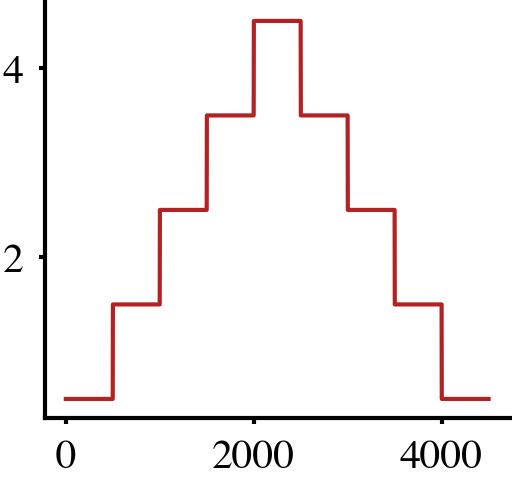

In [13]:
test_traj = 0.5 + staircase_function(5, 500)
plt.plot(test_traj)
plt.show()

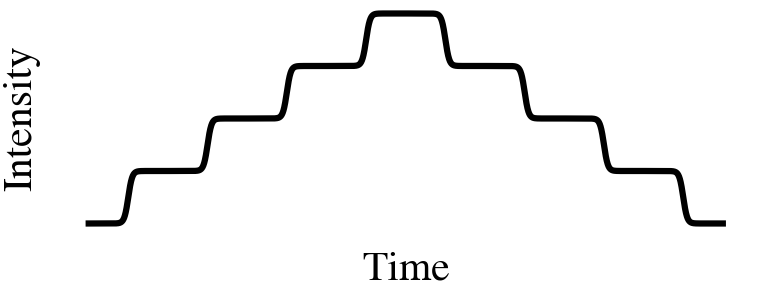

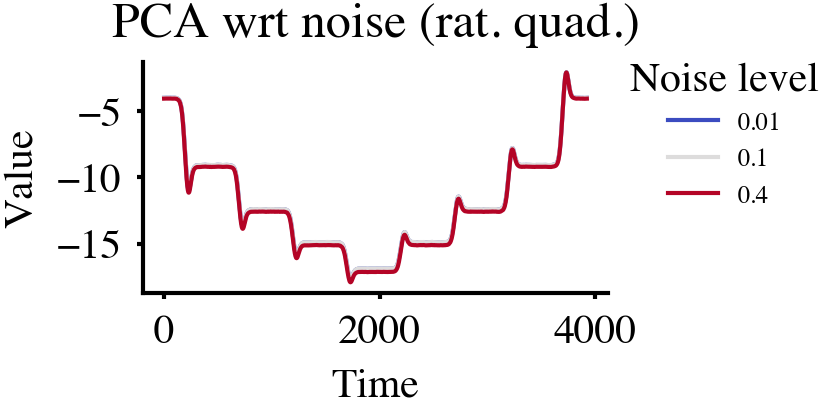

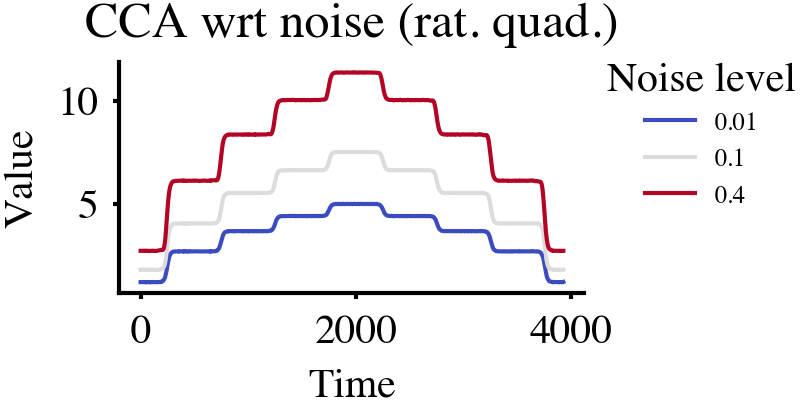

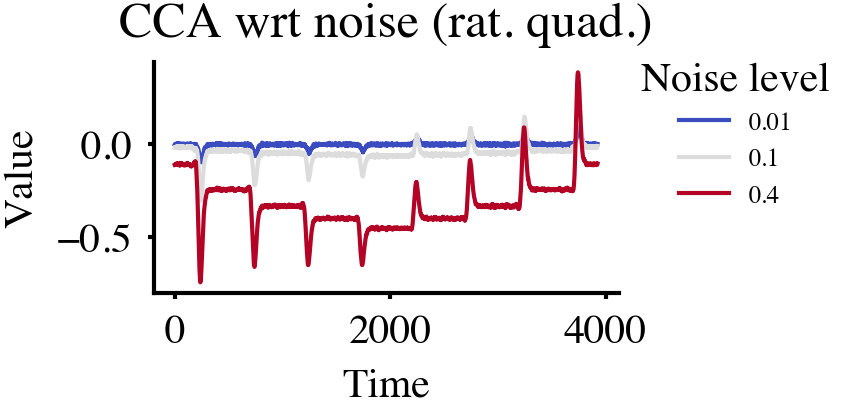

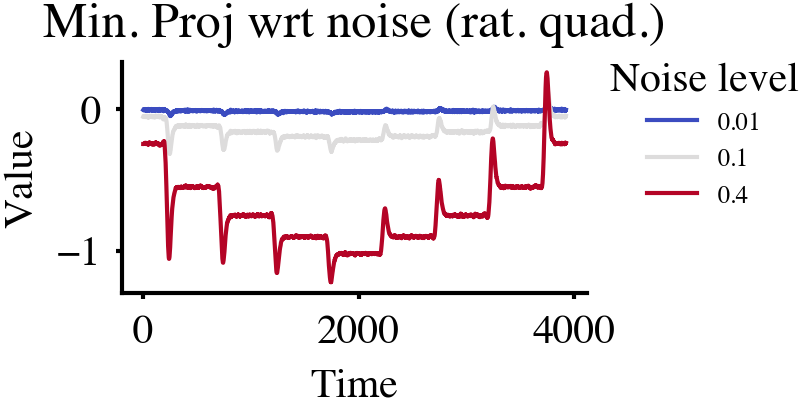

In [14]:
test_traj = test_traj_step(transient_length=500, num_steps=4, plot=True)
test_traj_log = np.log(test_traj)
# add noise to the test trajectory
noise_std = 0.002
test_traj_log_noise = test_traj_log + noise_std*np.random.randn(len(test_traj))

P_test = sp.linalg.hankel(test_traj_log_noise[:memory], test_traj_log_noise[memory-1:])

# # projection of the first and 2nd filter
# proj = filter3[:3,:]@P_test
filter_select = 1
# plot_filters_action(filters_dict, P_test, which_filter=0,title="", legend_title="", export_path=None)
pca_action = plot_filters_action(store_filters_rq_noise["pca"],
                    P_test, 
                    which_filter=filter_select,
                    title="PCA wrt noise (rat. quad.)",
                    legend_title="Noise level",
                    export_path=None,
                    return_action=True)

cca_action_1 = plot_filters_action(store_filters_rq_noise["cca"],
                    P_test, 
                    which_filter=0,
                    title="CCA wrt noise (rat. quad.)",
                    legend_title="Noise level",
                    export_path=None,
                    return_action=True)
cca_action_2 = plot_filters_action(store_filters_rq_noise["cca"],
                    P_test, 
                    which_filter=1,
                    title="CCA wrt noise (rat. quad.)",
                    legend_title="Noise level",
                    export_path=None,
                    return_action=True)
min_proj_action = plot_filters_action(store_filters_rq_noise["min_proj"],
                    P_test,
                    which_filter=filter_select,
                    title="Min. Proj wrt noise (rat. quad.)",
                    legend_title="Noise level",
                    export_path=None,
                    return_action=True)

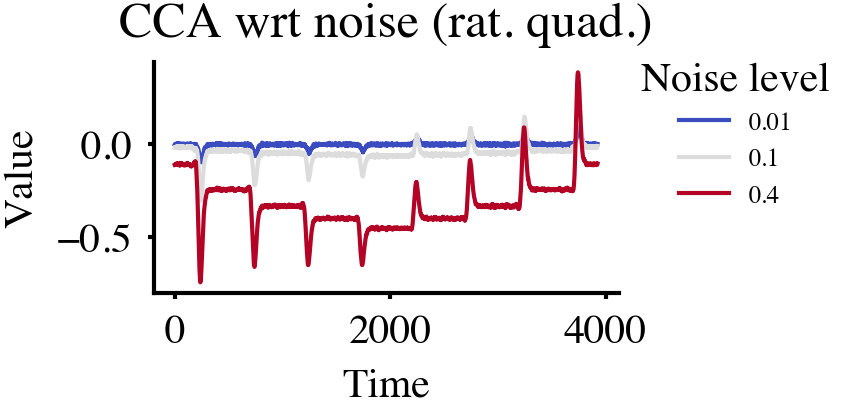

In [15]:
cca_actions = plot_filters_action(store_filters_rq_noise["cca"],
                    P_test, 
                    which_filter=filter_select,
                    title="CCA wrt noise (rat. quad.)",
                    legend_title="Noise level",
                    export_path=None,
                    return_action=True)

In [16]:

# save test trajectory
np.savez("./results/fig3_test_traj_step.npz", test_traj=test_traj, \
         test_traj_log=test_traj_log, test_traj_log_noise=test_traj_log_noise,\
         P_test=P_test, cca_flt_action1=cca_action_1, cca_flt_action2=cca_action_2)

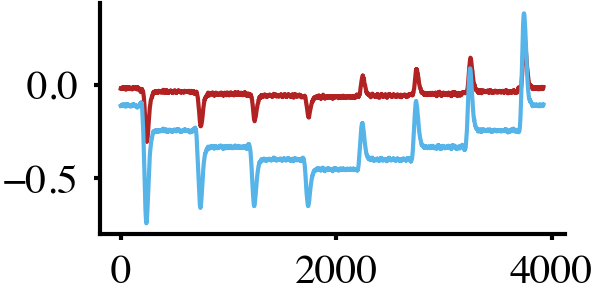

In [17]:
# plot the average action of the filters
fig, ax = plt.subplots(figsize=(2.0, 1))
for i, action in enumerate(cca_actions[1:]):
    mean_action = np.mean(action, axis=0)
    std_action = np.std(action, axis=0)
    ax.plot(mean_action, label=f"{noise_levels[i]}")
    # ax.fill_between(
    #     np.arange(len(mean_action)),
    #     mean_action - std_action,
    #     mean_action + std_action,
    #     alpha=0.1,
    #     lw=0,
    #     color=colors[i],
    # )
# plot the action of the last filter
plt.show()

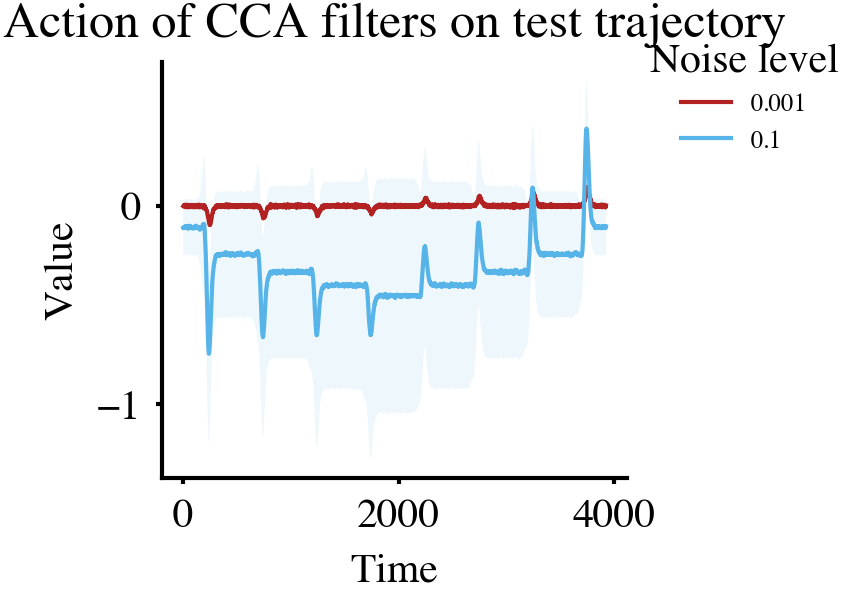

In [18]:
action_tanh_1 = np.array(cca_actions[0])
action_tanh_2 = np.array(cca_actions[2])

plt.plot(action_tanh_1.mean(axis=0), label="0.001")
plt.fill_between(
    np.arange(len(action_tanh_1.mean(axis=0))),
    action_tanh_1.mean(axis=0) - action_tanh_1.std(axis=0),
    action_tanh_1.mean(axis=0) + action_tanh_1.std(axis=0),
    alpha=0.1,
    lw=0,
)
plt.plot(action_tanh_2.mean(axis=0), label="0.1")
plt.fill_between(
    np.arange(len(action_tanh_2.mean(axis=0))),
    action_tanh_2.mean(axis=0) - action_tanh_2.std(axis=0),
    action_tanh_2.mean(axis=0) + action_tanh_2.std(axis=0),
    alpha=0.1,
    lw=0,
)
# plt.plot(test_traj, label="test trajectory", color="black")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# set y axis tick
plt.title("Action of CCA filters on test trajectory")
plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title="Noise level")
# plt.savefig("./figures/cca_action_test_traj.pdf", dpi=300, bbox_inches="tight")
plt.show()

Past filter

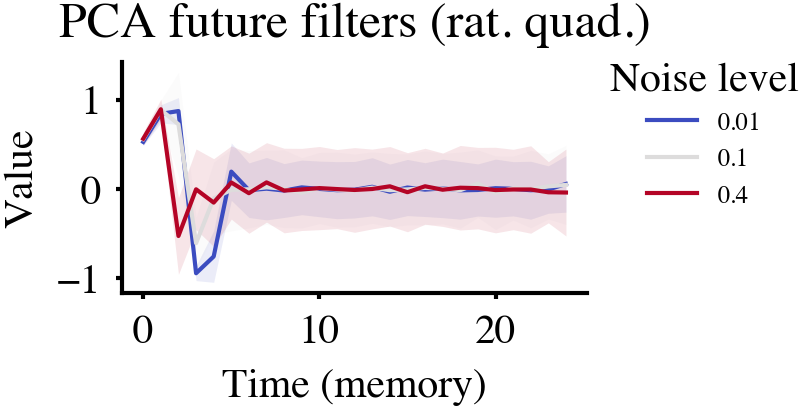

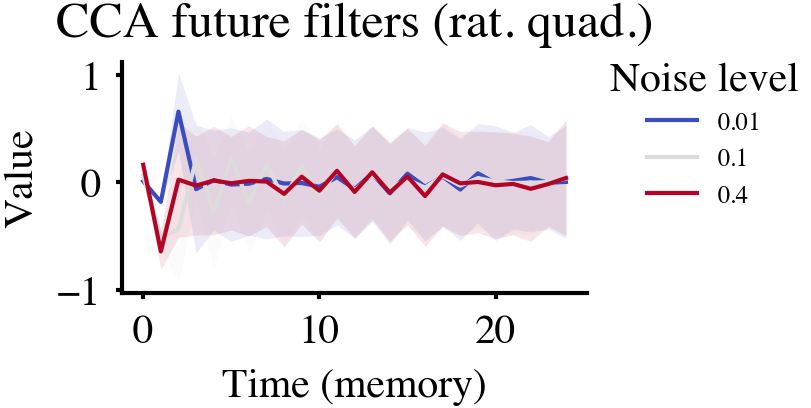

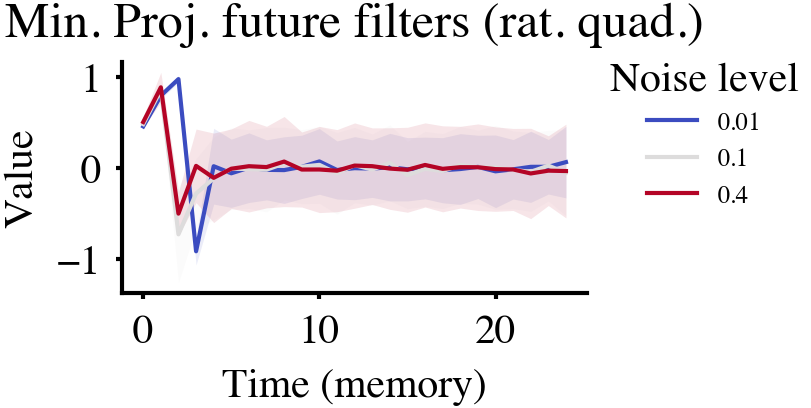

In [19]:
plot_filters_statistics(
    store_future_filters_rq_noise["pca"],
    which_filter=0,
    title="PCA future filters (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/pca_filters_noise_level_rq.pdf",
)

plot_filters_statistics(
    store_future_filters_rq_noise["cca"],
    which_filter=0,
    title="CCA future filters (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/cca_filters_noise_level_rq.pdf",
)

plot_filters_statistics(
    store_future_filters_rq_noise["min_proj"],
    which_filter=0,
    title="Min. Proj. future filters (rat. quad.)",
    legend_title="Noise level",
    # export_path="./figures/min_proj_filters_noise_level_rq.pdf",
)

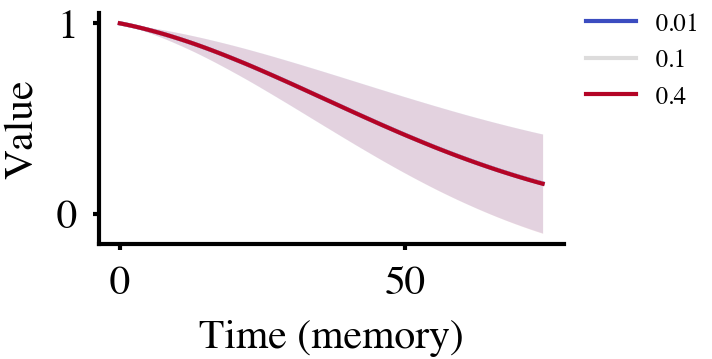

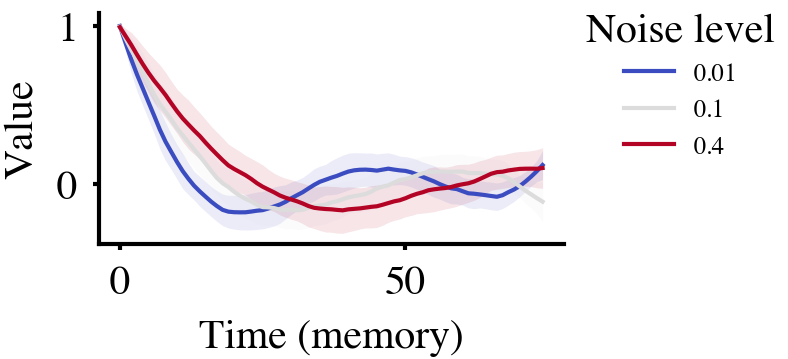

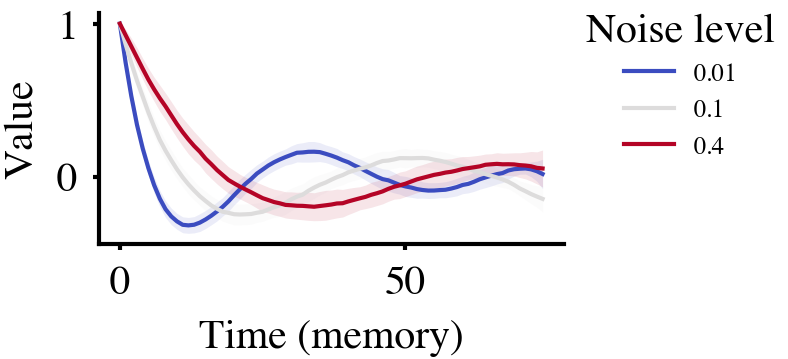

In [20]:
which_filter = 0
plot_filters_statistics(
    store_filters_gaussian_noise['pca'],
    which_filter=which_filter,
    # title="PCA filters wrt noise (exp. quad.)",
    # export_path="./figures/pca_filters_noise_level_exp_quad_flt_" + str(which_filter) + ".pdf",
)

plot_filters_statistics(
    store_filters_gaussian_noise['cca'],
    which_filter=which_filter,
    # title="CCA filters wrt noise (exp. quad.)",
    # export_path="./figures/cca_filters_noise_level_exp_quad_flt_" + str(which_filter) + ".pdf",
    legend_title="Noise level",
)

plot_filters_statistics(
    store_filters_gaussian_noise['min_proj'],
    which_filter=which_filter,
    # title="Min projection filters wrt noise (exp. quad.)",
    # export_path="./figures/minproj_filters_noise_level_exp_quad_flt_" + str(which_filter) + ".pdf",
    legend_title="Noise level",
)

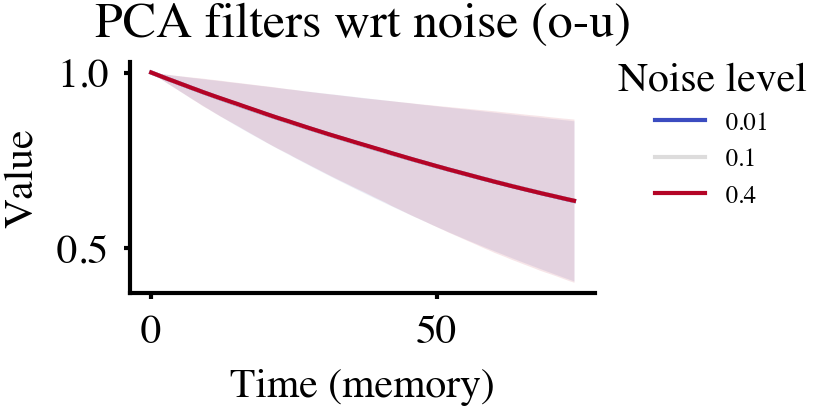

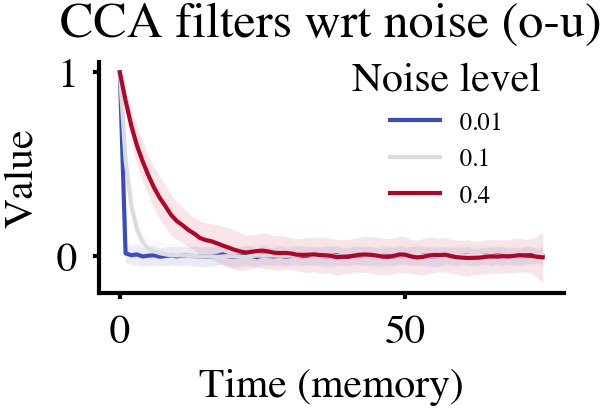

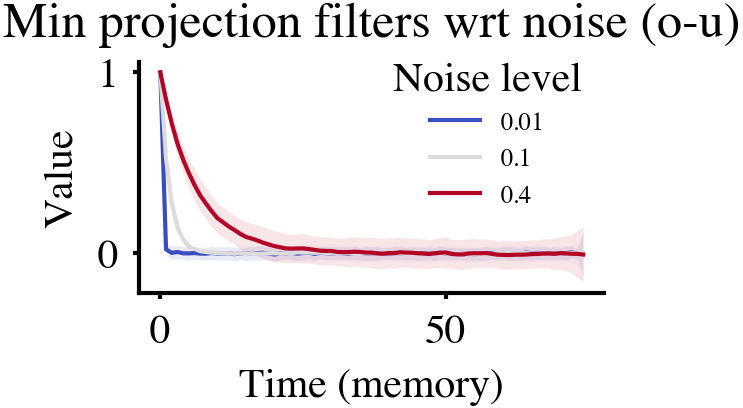

In [21]:
plot_filters_statistics(
    store_filters_ou_noise['pca'],
    which_filter=0,
    title="PCA filters wrt noise (o-u)",
    # export_path=".figures/pca_filters_noise_level_ou.pdf",
    legend_title="Noise level",
)

plot_filters_statistics(
    store_filters_ou_noise['cca'],
    which_filter=0,
    title="CCA filters wrt noise (o-u)",
    # export_path="./figures/cca_filters_noise_level_ou.pdf",
    legend_title="Noise level",
)

plot_filters_statistics(
    store_filters_ou_noise['min_proj'],
    which_filter=0,
    title="Min projection filters wrt noise (o-u)",
    # export_path="./figures/minproj_filters_noise_level_ou.pdf",
    legend_title="Noise level",
)

### Plot the canonical correlation for the cca method


Text(0, 0.5, 'Corr. Coeff.')

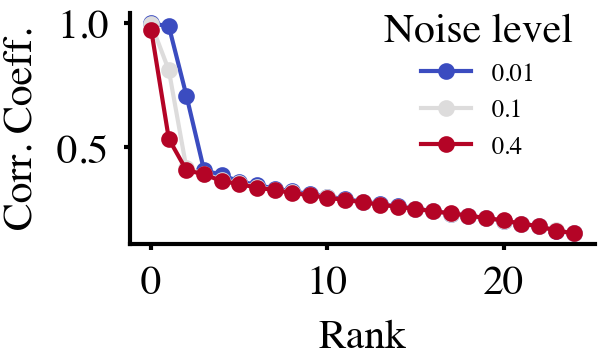

In [22]:
fig, ax = plt.subplots(figsize=(2.0, 1))

# Define colors using a colormap
colors = plt.cm.coolwarm(np.linspace(0, 1, len(store_cca_rq_singular_values)))

for k, noise_level in enumerate(store_cca_rq_singular_values):
    singular_values = np.array(
        np.array(
            [
                singular_values
                for singular_values in store_cca_rq_singular_values[noise_level]
            ]
        )
    )
    singular_values_mean = singular_values.mean(axis=0)
    singular_values_std = singular_values.std(axis=0)

    ax.plot(singular_values_mean, 'o-',label=f"{noise_level}", color=colors[k])
    # ax.fill_between(
    #     np.arange(len(singular_values_mean)),
    #     singular_values_mean - singular_values_std,
    #     singular_values_mean + singular_values_std,
    #     alpha=0.1,
    #     lw=0,
    #     # color=colors[k],
    # )
# plt.yscale("symlog")
plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title="Noise level")
plt.xlabel("Rank")
plt.ylabel("Corr. Coeff.")
# plt.title("CCA singular values wrt noise (rat. quad.)")
# fig.savefig(
#     "./poster_figures/cca_singular_values_noise_level_rq.pdf", dpi=300, bbox_inches="tight"
# )


### Plot the mutual information for the cca method
The mutual information is defined as
$$
I = -\frac{1}{2} \log(1 - \rho^2)
$$
where $\rho$ is the canonical correlation. The mutual information is a measure of the amount of information that one random variable contains about another random variable. It is a non-negative value, and it is equal to zero if and only if the two random variables are independent.
$$

Text(0, 0.5, 'Information (bits)')

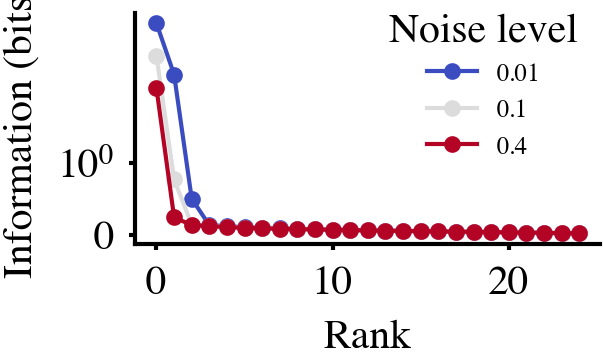

In [23]:
# plot the contritbuion of each rank to the mutual information
fig, ax = plt.subplots(figsize=(2.0, 1))
for k, noise_level in enumerate(store_cca_rq_singular_values):
    singular_values = np.array(
        np.array(
            [
                singular_values
                for singular_values in store_cca_rq_singular_values[noise_level]
            ]
        )
    )
    singular_values_mean = singular_values.mean(axis=0)
    singular_values_std = singular_values.std(axis=0)

    ax.plot(np.arange(len(singular_values_mean)), -np.log2(1-singular_values_mean**2)/2, 'o-',label=f"{noise_level}", color=colors[k])
    # ax.fill_between(
    #     np.arange(len(singular_values_mean)),
    #     singular_values_mean - singular_values_std,
    #     singular_values_mean + singular_values_std,
    #     alpha=0.1,
    #     lw=0,
    #     # color=colors[k],
    # )
plt.yscale("symlog")
plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title="Noise level")
plt.xlabel("Rank")
plt.ylabel("Information (bits)")
# plt.title("CCA singular values wrt noise (rat. quad.)")

Text(0, 0.5, 'Corr. Coeff.')

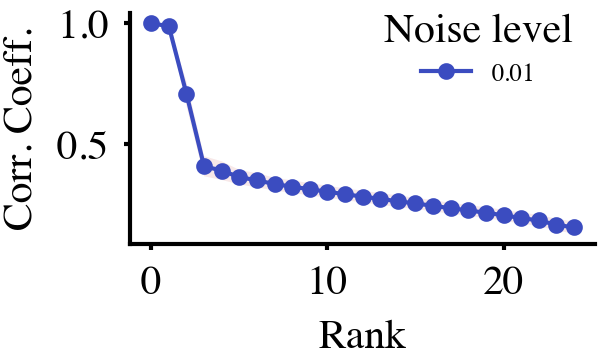

In [24]:
noise_level = 0.01
singular_values = np.array(
    np.array(
        [
            singular_values
            for singular_values in store_cca_rq_singular_values[noise_level]
        ]
    )
)
singular_values_mean = singular_values.mean(axis=0)
singular_values_std = singular_values.std(axis=0)


# plot the correlation coefficient of the first 10 ranks and add shaded area for std
fig, ax = plt.subplots(figsize=(2.0, 1))
ax.plot(np.arange(len(singular_values_mean)), singular_values_mean, 'o-',label=f"{noise_level}", color=colors[0])
ax.fill_between(
    np.arange(len(singular_values_mean)),
    singular_values_mean - singular_values_std,
    singular_values_mean + singular_values_std,
    alpha=0.1,
    lw=0,
    # color=colors[k],
)
# plt.yscale("symlog")
plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title="Noise level")
plt.xlabel("Rank")
plt.ylabel("Corr. Coeff.")
# plt.title("CCA singular values wrt noise (rat. quad.)")
# fig.savefig(
#     "./poster_figures/cca_singular_values_noise_level_rq_0.01.pdf", dpi=300, bbox_inches="tight"
# )


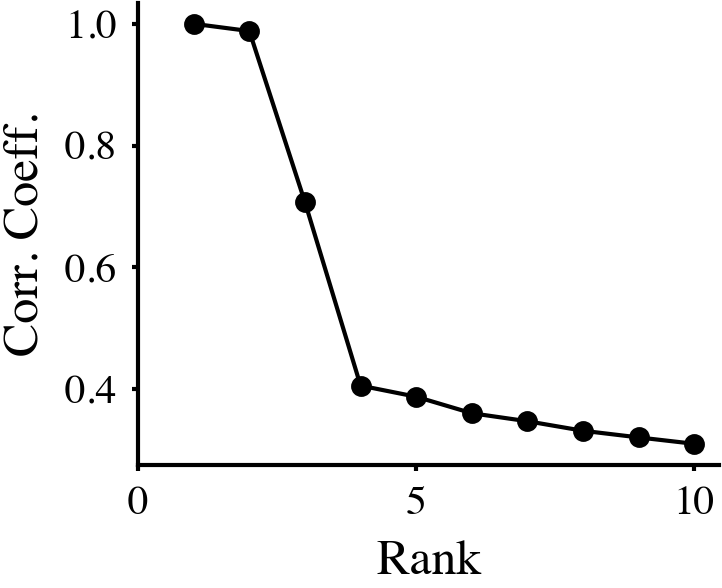

In [25]:
rank_cut = 10
fig, ax = plt.subplots(figsize=(2.5, 2))
ax.plot(np.arange(1,1+rank_cut), singular_values_mean[:rank_cut], 'o-',label=f"{noise_level}", color='k', markersize=4)
# ax.fill_between(
#     np.arange(rank_cut),
#     singular_values_mean[:rank_cut] - singular_values_std[:rank_cut],
#     singular_values_mean[:rank_cut] + singular_values_std[:rank_cut],
#     alpha=0.1,
#     lw=0,
#     # color=colors[k],
# )
# plt.yscale("symlog")
# plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1))
plt.xlabel("Rank")
plt.ylabel("Corr. Coeff.")
xticks = [0, 5, 10]
plt.xticks(xticks, xticks)
# set font size
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
# set x and y axis width
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
# set xlabel font size
plt.xlabel("Rank", fontsize=12)
plt.ylabel("Corr. Coeff.", fontsize=12)

# plt.title("CCA singular values wrt noise (rat. quad.)")
# fig.savefig(
#     # "./poster_figures/cca_singular_values_noise_level_rq_0.01.pdf", dpi=300, bbox_inches="tight"
# )
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './figures/cca_singular_values_noise_level_rq_0.01_individual_Info.pdf'

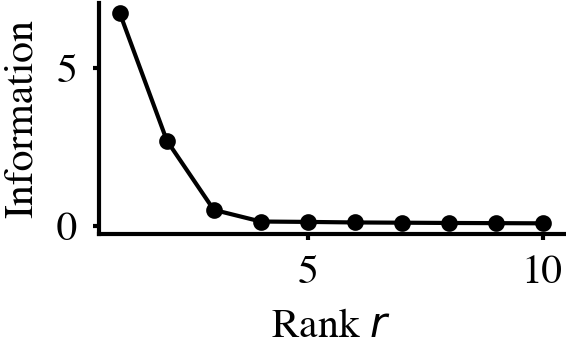

In [26]:
rank_cut = 10
fig, ax = plt.subplots(figsize=(2.0, 1))
ax.plot(np.arange(1,1+len(singular_values_mean[:rank_cut])), -np.log2(1-singular_values_mean[:rank_cut]**2)/2, 'o-',label=f"{noise_level}", color='k')
# plt.yscale("symlog")
plt.xlabel(r"Rank $r$")
# plt.ylabel(r"-1/2 log(1 - $\rho_r^2$)")
plt.ylabel(r"Information")
# plt.legend(ncols=1, bbox_to_anchor=(1.0, 1.1), title="Noise level")
# plt.title("CCA singular values wrt noise (rat. quad.)")
fig.savefig(
    "./figures/cca_singular_values_noise_level_rq_0.01_individual_Info.pdf", dpi=300, bbox_inches="tight"
)
# plot the contribution of each rank to the mutual information
# fig, ax = plt.subplots(figsize=(2.0, 1)) 

Text(0, 0.5, ' $I_r$')

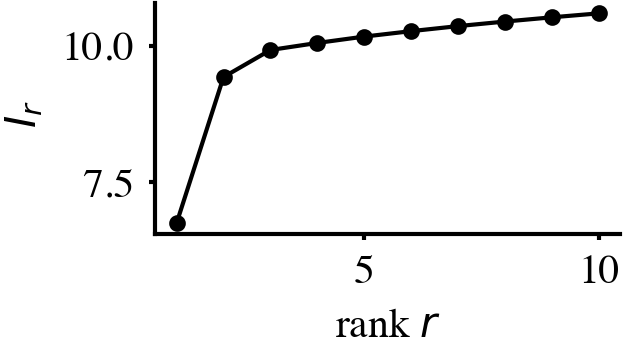

In [ ]:
rank_cut = 10
I_rank = -np.log2(1-singular_values_mean[:rank_cut]**2)/2
# cumulate the information
I_rank_cum = np.cumsum(I_rank)
fig, ax = plt.subplots(figsize=(2.0, 1))
ax.plot(np.arange(1,1+len(singular_values_mean[:rank_cut])), I_rank_cum, 'o-',label=f"{noise_level}", color='k')
# plt.yscale("symlog")
plt.xlabel(r"rank $r$")
plt.ylabel(r" $I_r$")
# save the figure as pdf
# fig.savefig(
#     "./figures/cca_singular_values_noise_level_rq_0.01_cum_Info.pdf", dpi=300, bbox_inches="tight"
# )
# plot the contribution of each rank to the mutual information

In [ ]:
future_flts = store_future_filters_rq_noise['min_proj'][0.01]
future_first = [f1[:,0]/np.max(abs(f1[:,0])) for f1 in future_flts]
# make it an array
future_first = np.vstack(future_first)
future_first.shape
future_mean = future_first.mean(axis=0)
future_std = future_first.std(axis=0)

# past filter
past_flts = store_filters_rq_noise['min_proj'][0.01]
past_first = [f1[0,:]/np.max(abs(f1[0,:])) for f1 in past_flts]
# make it an array
past_first = np.vstack(past_first)
past_first.shape
past_mean = past_first.mean(axis=0)
past_std = past_first.std(axis=0)


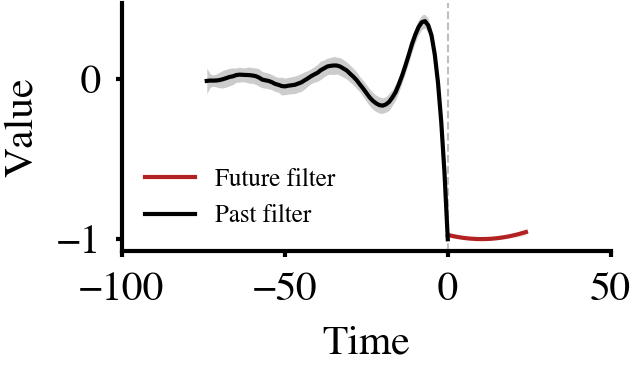

In [ ]:
noise_level = 0.01
future_time = np.arange(0, horizon)
past_time = np.arange(-memory+1,1)

fig, ax = plt.subplots(figsize=(2.5, 1.5))
ax.plot(future_time, future_mean,  color="firebrick",label="Future filter")  
# ax.plot(future_mean, label=f"{noise_level}", color=firebrick)
ax.fill_between(
    np.arange(len(future_mean)),
    future_mean - future_std,
    future_mean + future_std,
    alpha=0.1,
    lw=0,
    color="firebrick",
)
# add vertical line at x = 0
plt.axvline(x=0, color="grey", ls="--", alpha=0.5,linewidth=0.5)
ax.plot(past_time, np.flip(past_mean),  color="black",label="Past filter")
# ax.plot(papast_mean, label=f"{noise_level}", color=black)
ax.fill_between(
    past_time,
    np.flip(past_mean - past_std),
    np.flip(past_mean + past_std),
    alpha=0.2,
    lw=0,
    color="black",
)
# set x ticks
plt.xticks(np.arange(-100, 51, 50))
# add x axis label
plt.xlabel("Time")
plt.ylabel("Value")
# show the labels
plt.legend()

# tight layout
plt.tight_layout()
# save the figure
# plt.savefig("./figures/future_past_filters_rq.pdf", dpi=300, bbox_inches="tight")

# Test the effect of lag

In [ ]:
# use the data with smallest noise
future_flts = store_future_filters_rq_noise['min_proj'][0.01]
future_first = [f1[:,0]/np.max(abs(f1[:,0])) for f1 in future_flts]
# make it an array
future_first = np.vstack(future_first)
future_first.shape
future_mean = future_first.mean(axis=0)
future_std = future_first.std(axis=0)


# past filter
past_flts = store_filters_rq_noise['min_proj'][0.01]
past_first = [f1[0,:]/np.max(abs(f1[0,:])) for f1 in past_flts]
# make it an array
past_first = np.vstack(past_first)
past_first.shape
past_mean = past_first.mean(axis=0)
past_std = past_first.std(axis=0)

In [ ]:
lag_levels = np.arange(25,100,20)

store_filters_gaussian_lag = {method: {round(lag,3): [] for lag in lag_levels} for method in ["pca", "cca", "min_proj"]}
store_filters_ou_lag = {method: {round(lag,3): [] for lag in lag_levels} for method in ["pca", "cca", "min_proj"]}
store_filters_rq_lag = {method: {round(lag,3): [] for lag in lag_levels} for method in ["pca", "cca", "min_proj"]}

for lag_level in tqdm(lag_levels):
    for gaussian_i in range(gaussian_functions.shape[0]):

        # GAUSSIAN
        predict_future_gauss = PredictFuture(
            gaussian_functions[gaussian_i,:] + np.random.normal(0, 0.001, nb_of_samples),
            memory=lag_level,
            horizon=lag_level,
            rank=None,
        )

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_gauss.predict_future(method="pca")
        )
        store_filters_gaussian_lag['pca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_gauss.predict_future(method="cca")
        )
        store_filters_gaussian_lag['cca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter,_ = (
            predict_future_gauss.predict_future(method="min_proj")
        )
        store_filters_gaussian_lag['min_proj'][round(lag_level,3)].append(past_filter)


        # O-U Process
        predict_future_ou = PredictFuture(
            ou_functions[gaussian_i,:] + np.random.normal(0, 0.001, nb_of_samples),
            memory=lag_level,
            horizon=lag_level,
            rank=None,
        )
        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_ou.predict_future(method="pca")
        )
        store_filters_ou_lag['pca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_ou.predict_future(method="cca")
        )
        store_filters_ou_lag['cca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_ou.predict_future(method="min_proj")
        )
        store_filters_ou_lag['min_proj'][round(lag_level,3)].append(past_filter)

        # Rational Quadratic
        predict_future_rq = PredictFuture(
            rq_functions[gaussian_i,:] + np.random.normal(0, 0.001, nb_of_samples),
            memory=lag_level,
            horizon=lag_level,
            rank=None,
        )
        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_rq.predict_future(method="pca")
        )
        store_filters_rq_lag['pca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _ = (
            predict_future_rq.predict_future(method="cca")
        )
        store_filters_rq_lag['cca'][round(lag_level,3)].append(past_filter)

        future_prediction, x_partial, future_filter, past_filter, _  = (
            predict_future_rq.predict_future(method="min_proj")
        )
        store_filters_rq_lag['min_proj'][round(lag_level,3)].append(past_filter)



100%|██████████| 4/4 [02:16<00:00, 34.10s/it]


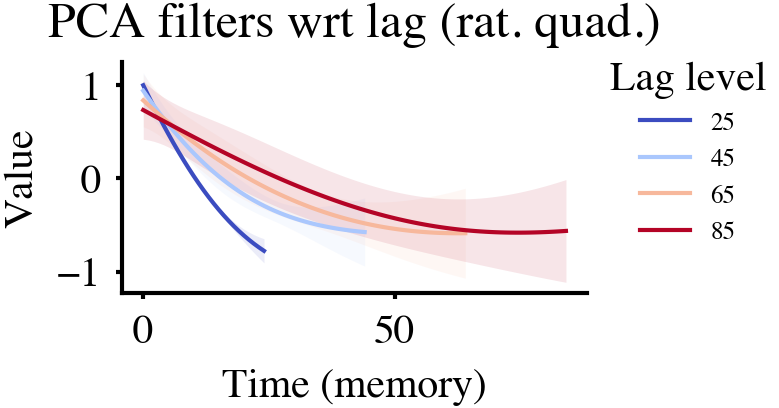

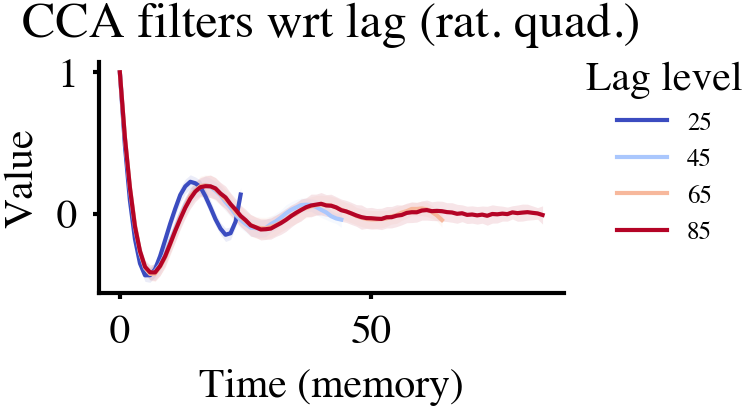

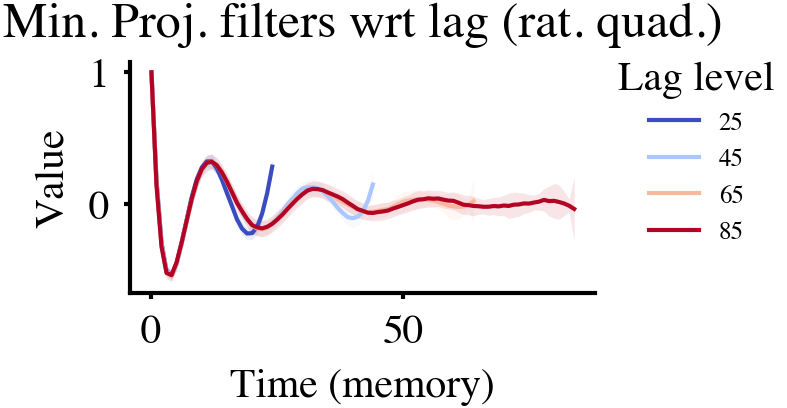

In [ ]:
filter_sel = 1
plot_filters_statistics(
    store_filters_rq_lag["pca"],
    which_filter=filter_sel,
    title="PCA filters wrt lag (rat. quad.)",
    legend_title="Lag level",
    # export_path="./figures/pca_filters_lag_rq.pdf",
)

plot_filters_statistics(
    store_filters_rq_lag["cca"],
    which_filter=filter_sel,
    title="CCA filters wrt lag (rat. quad.)",
    legend_title="Lag level",
    # export_path="./figures/cca_filters_lag_rq.pdf",
)

plot_filters_statistics(
    store_filters_rq_lag["min_proj"],
    which_filter=filter_sel,
    title="Min. Proj. filters wrt lag (rat. quad.)",
    legend_title="Lag level",
    # export_path="./figures/min_proj_filters_lag_rq.pdf",
)

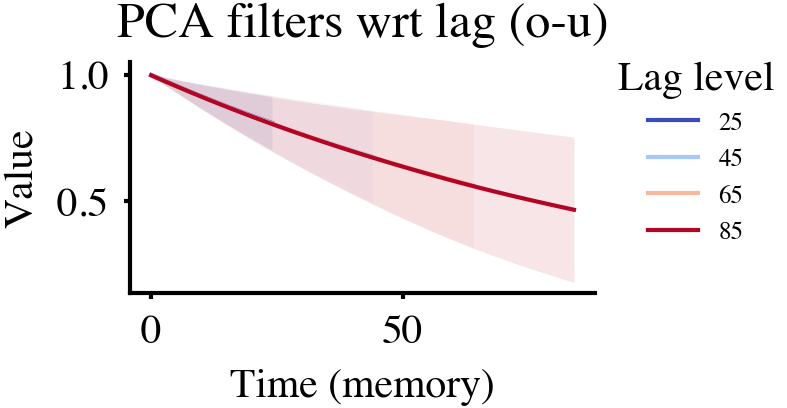

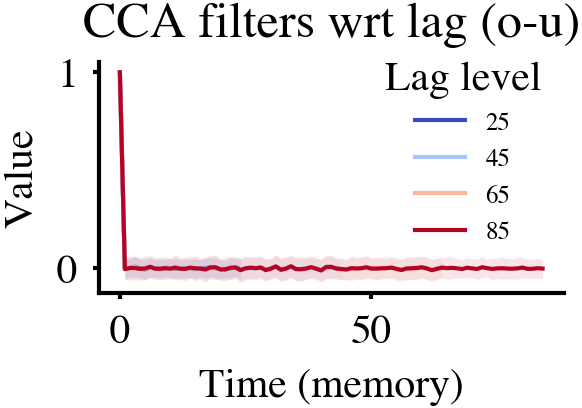

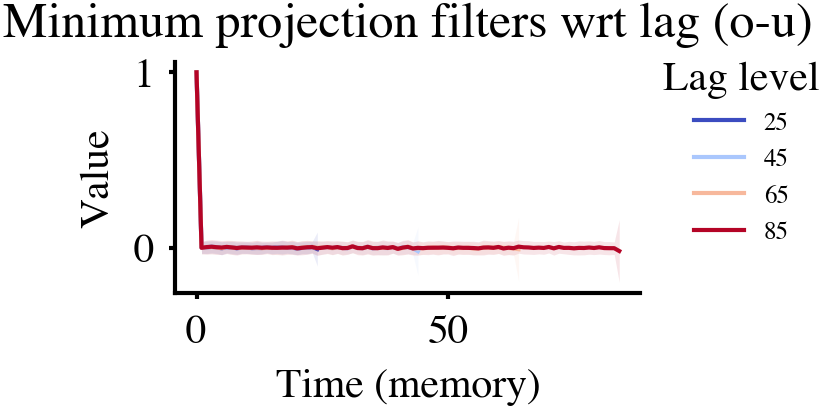

In [ ]:
plot_filters_statistics(
    store_filters_ou_lag['pca'],
    which_filter=0,
    title="PCA filters wrt lag (o-u)",
    export_path="./figures/pca_filters_lag_level_ou.pdf",
    legend_title="Lag level",
)

plot_filters_statistics(
    store_filters_ou_lag['cca'],
    which_filter=0,
    title="CCA filters wrt lag (o-u)",
    export_path="./figures/cca_filters_lag_level_ou.pdf",
    legend_title="Lag level",
)

plot_filters_statistics(
    store_filters_ou_lag['min_proj'],
    which_filter=0,
    title="Minimum projection filters wrt lag (o-u)",
    export_path="./figures/minproj_filters_lag_level_ou.pdf",
    legend_title="Lag level",
)

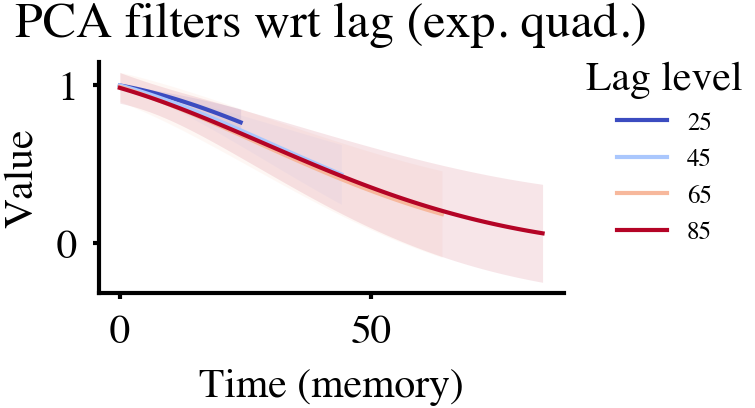

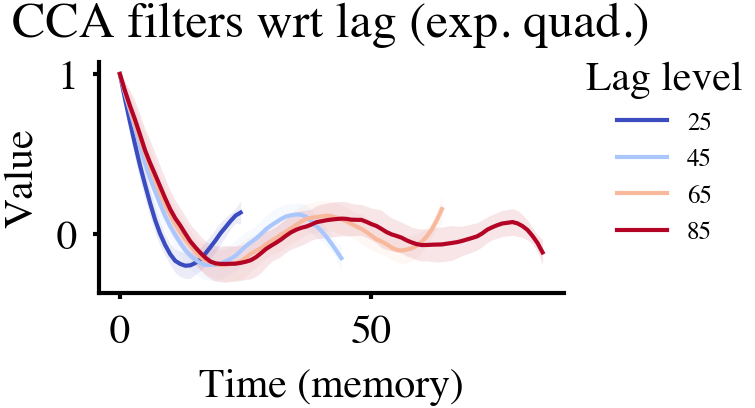

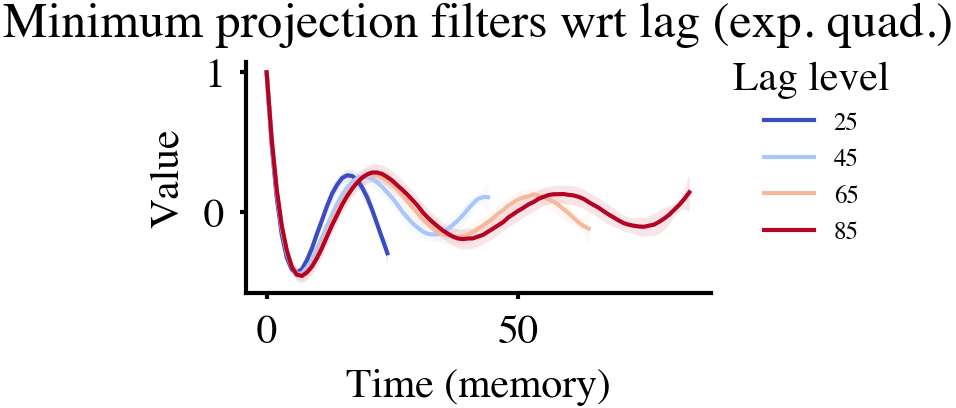

In [ ]:
plot_filters_statistics(
    store_filters_gaussian_lag['pca'],
    which_filter=0,
    title="PCA filters wrt lag (exp. quad.)",
    export_path="./figures/pca_filters_lag_level_exp_quad.pdf",
    legend_title="Lag level",
)

plot_filters_statistics(
    store_filters_gaussian_lag['cca'],
    which_filter=0,
    title="CCA filters wrt lag (exp. quad.)",
    # export_path="./figures/cca_filters_lag_level_exp_quad.pdf",
    legend_title="Lag level",
)

plot_filters_statistics(
    store_filters_gaussian_lag['min_proj'],
    which_filter=0,
    title="Minimum projection filters wrt lag (exp. quad.)",
    # export_path="./figures/minproj_filters_lag_level_exp_quad.pdf",
    legend_title="Lag level",
)

## Supplemenary figures

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt


def cca_plots(write_to_file=False):
    # define kernel
    l = 2.0
    ker = lambda t1, t2, l: 1 / (1 + np.abs((t1 - t2) / l) ** 2)

    # set up subplots
    neigs = 1
    fig, axs = plt.subplots(neigs + 1, 1, figsize=(5, 7))
    fig.tight_layout(pad=4.0)

    # construct grid
    dt = 0.05
    lpast1 = 40
    lfuture1 = lpast1
    lpast2 = 20
    lfuture2 = lpast2

    # write generated plot to file
    filename = f'cca_{lpast1}_{lpast2}.png'

    # run cca
    ts = dt * np.arange(-lpast1, lpast1)
    psi1, corr_coef1 = do_cca(ker, l, ts, lpast1, lfuture1)
    ts = dt * np.arange(-lpast2, lpast2)
    psi2, corr_coef2 = do_cca(ker, l, ts, lpast2, lfuture2)

    # plot the canonical directions
    for i in range(neigs):
        axs[i].plot(lpast1 - np.arange(lpast1), np.flip(psi1[:, i]), label=f'$\\ell = {lpast1}$')
        axs[i].plot(lpast1 - np.arange(lpast2), np.flip(psi2[:, i]), label=f'$\\ell = {lpast2}$')
        xticks = np.arange(0, lpast1+1, 5)
        axs[i].set_xticks(xticks)
        xtick_labels = [str(-(lpast1 - xtick)) for xtick in xticks]
        axs[i].set_xticklabels(xtick_labels)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].axhline(0, color='black', linewidth=0.5)
        axs[i].set_xlabel('Lag Time')
        axs[i].set_ylabel('arb. units')
        axs[i].legend()
        axs[i].set_title(f'$\\Psi_{i + 1}$')

    # plot canonical correlations
    axs[neigs].plot(np.arange(lfuture1) + 1, corr_coef1[:lfuture1],
                    marker='x', markersize=6, label=f'$\\ell = {lpast1}$', alpha=1.0, linestyle='none')
    axs[neigs].plot(np.arange(lfuture2) + 1, corr_coef2[:lfuture2],
                    marker='.', markersize=7, label=f'$\\ell = {lpast2}$', alpha=1.0, linestyle='none')
    axs[neigs].axhline(0, color='black', linewidth=0.5)
    axs[neigs].set_ylabel('canonical correlation')
    axs[neigs].set_xlabel('Order')
    axs[neigs].spines['top'].set_visible(False)
    axs[neigs].spines['right'].set_visible(False)
    axs[neigs].legend()
    plt.legend()

    if write_to_file:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def mutual_info_plot(write_to_file=False):
    # define kernel
    l = 2.0
    ker = lambda t1, t2, l: 1 / (1 + np.abs((t1 - t2) / l) ** 2)

    # filename for plot output
    filename = f'mutual_info.png'

    # define grid
    dt = 0.05
    ns = np.arange(2, 40, 2)
    mis = np.zeros(np.size(ns))
    for i, n in enumerate(ns):
        ts = dt * np.arange(-n, n)
        _, corr_coefs = do_cca(ker, l, ts, n, n)
        mis[i] = -0.5 * np.sum(np.log(1 - corr_coefs**2))

    # plot
    plt.plot(ns, mis, marker='.', color='black', markersize=8)
    plt.xlabel('$\\ell$', fontsize=20)
    plt.ylabel('Information (nats)', fontsize=16)
    if write_to_file:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


def do_cca(ker, l, ts, lpast, lfuture):
    """
    compute canonical directions and correlations for a kernel covariance matrix
    """
    # kernel matrix
    kmat = generate_kernel_matrix(ts, kernel_func=ker, l=l)
    cpp = kmat[:lpast, :lpast]
    cfp = kmat[lpast:lpast + lfuture, :lpast]
    cff = kmat[lpast:lpast + lfuture, lpast:lpast + lfuture]

    # cca
    up, sp, vpt = np.linalg.svd(cpp)
    vp = vpt.T
    if lfuture == 1:
        vect = cff**(-1/2) * cfp @ vp @ np.diag(sp ** (-0.5)) @ up.T
        corr_coef = np.linalg.norm(vect)
        psi = vect / np.linalg.norm(vect)
    else:
        # svd of cff to invert cff
        uf, sf, vft = np.linalg.svd(cff)
        vf = vft.T
        mat1 = vf @ np.diag(sf**(-0.5)) @ uf.T @ cfp @ vp @ np.diag(sp**(-0.5)) @ up.T
        # svd of mat1 to invert mat1
        u, s, vt = np.linalg.svd(mat1)
        v = vt.T
        psi = vp @ np.diag(sp**(-0.5)) @ up.T @ v
        psi = psi / np.linalg.norm(psi, axis=0)
        corr_coef = s

    # singular vectors are only defined up to a sign
    for i in range(psi.shape[1]):
        if psi[-1, i] < 0:
            psi[:, i] *= -1

    return psi, corr_coef


def generate_kernel_matrix(ts, kernel_func, **kwargs):
    """
    Generate covariance matrix for given time points using the specified kernel
    """
    n = len(ts)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_func(ts[i], ts[j], **kwargs)

    # Add small jitter
    K += 1e-8 * np.eye(n)

    return K

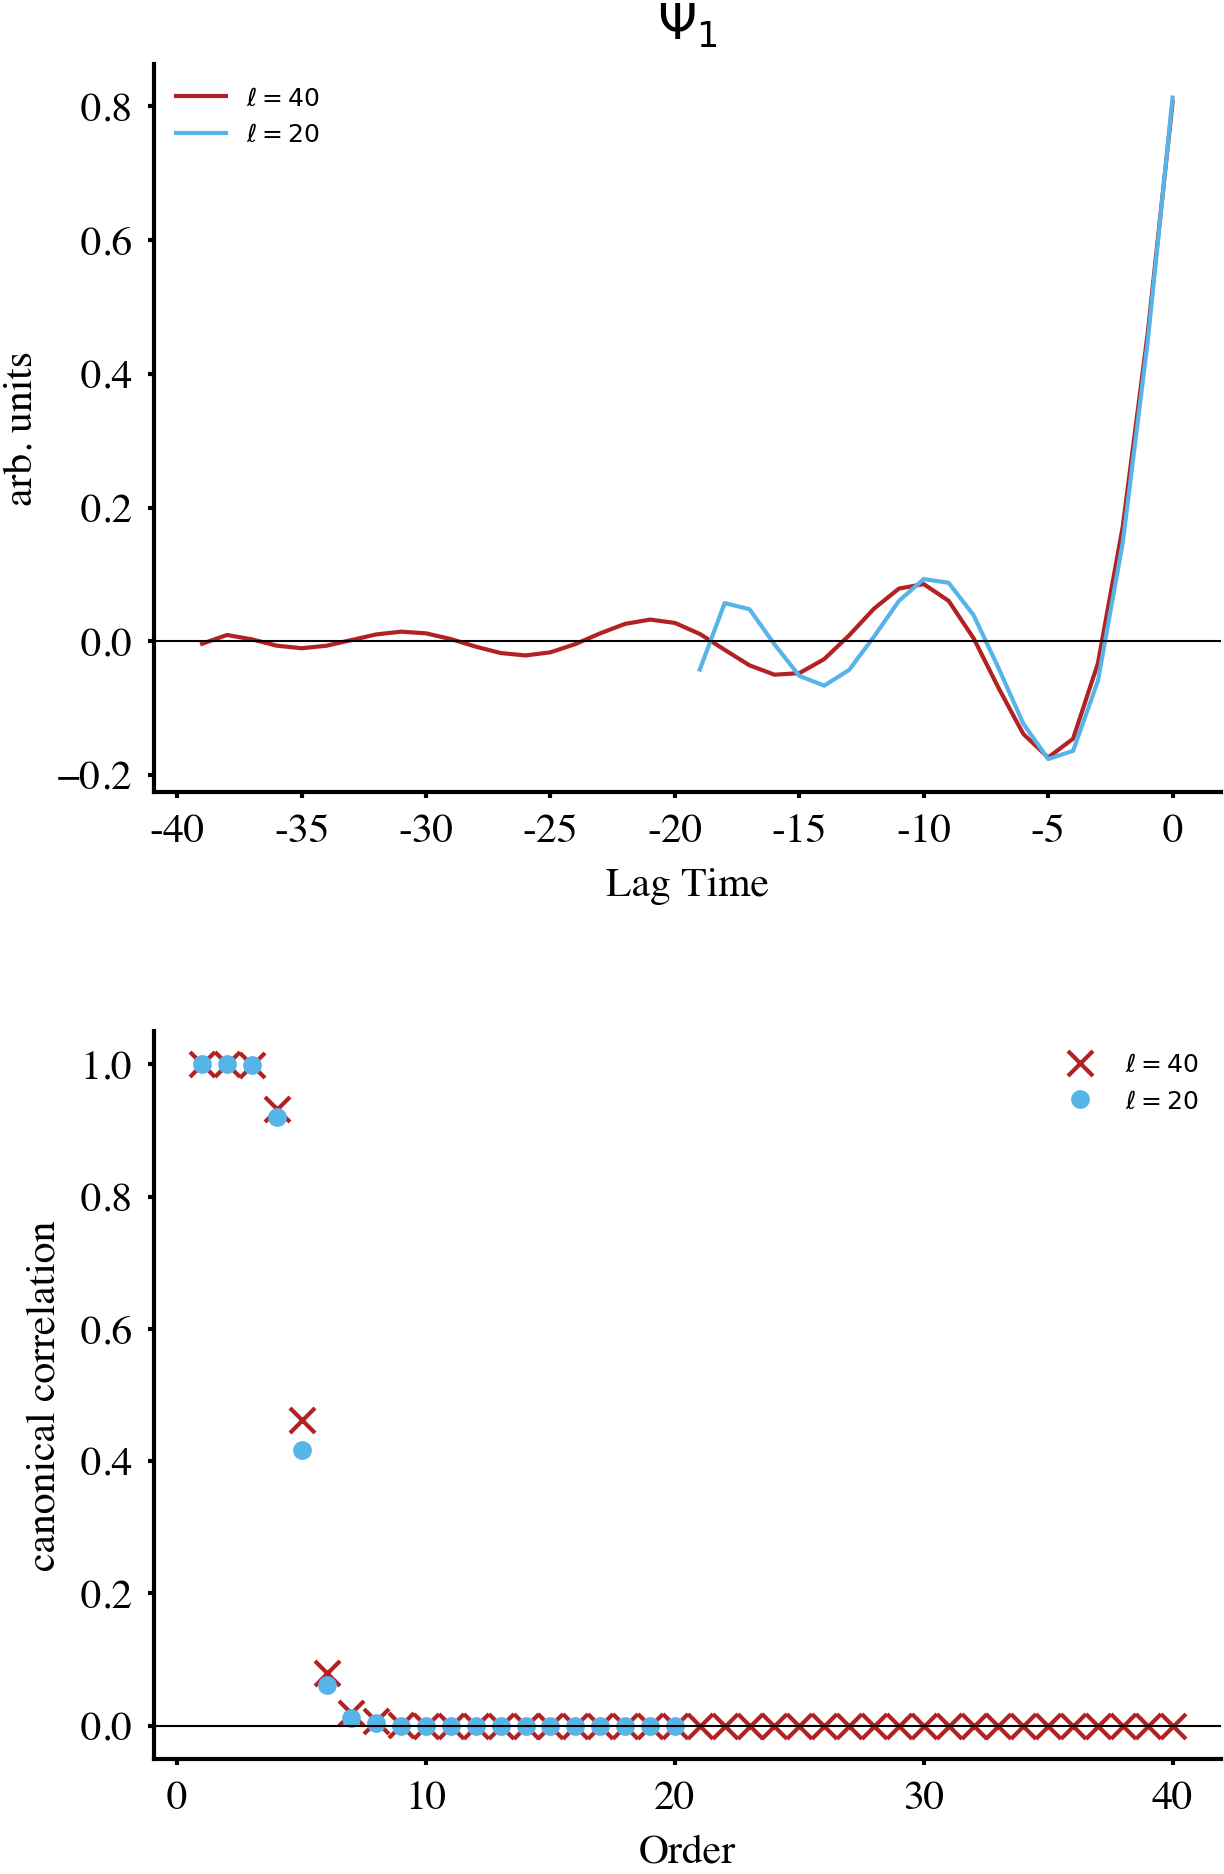

In [28]:
cca_plots(write_to_file=False)

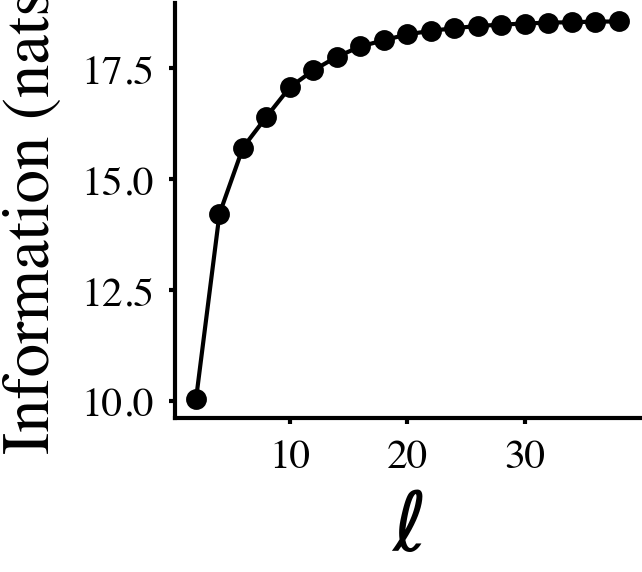

In [29]:
mutual_info_plot(write_to_file=False)